In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import core.config as config
from core.model_loader import load_pretrained_VAE
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE
from core.visualize import plot_hist, AUROC

from tqdm import tqdm

# CIFAR10

In [20]:
train_dist = 'cifar10'
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=train_dist, ngf=256, nz=200, beta=1)

dicts = [ netE.conv1.weight]

# Train in eval mode

In [21]:
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

netE.eval()
netG.eval()

for p in netE.parameters():
    p.requires_grad = False
for p in netG.parameters():
    p.requires_grad = False
for p in netE.conv1.parameters():
    p.requires_grad = True
for p in netE.conv2.parameters():
    p.requires_grad = True

optimizer1 = optim.Adam(netE.parameters(), lr=1e-4)
optimizer2 = optim.Adam(netG.parameters(), lr=1e-4)

device = 'cuda:0'

dataset = dset.CIFAR10( root=opt.dataroot, download=True,train = True,
                                transform=transforms.Compose([
                                   transforms.Resize((opt.imageSize)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                               ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                        shuffle=True, num_workers=int(opt.workers))

for epoch in range(10):
    LOSS = []
    for i, (x, _) in tqdm(enumerate(dataloader)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        x = x.to(device)
        [z,mu,logvar] = netE(x)
        recon = netG(z)
        loss = VAE_loss(x, [recon, mu, logvar], beta=opt.beta)
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        LOSS.append(loss.detach().cpu())
        if i%100==99:
            print(torch.sum(LOSS/100).item())
            LOSS = []

Files already downloaded and verified
tensor(11271.6426)
tensor(11249.7715)
tensor(11265.3496)
tensor(11249.5312)
tensor(11229.7715)
tensor(11244.8750)
tensor(11247.0391)
tensor(11241.2666)
tensor(11231.7949)
tensor(11238.8936)
tensor(11252.7471)
tensor(11263.1777)
tensor(11238.5098)
tensor(11247.7285)
tensor(11233.2998)
tensor(11257.3613)
tensor(11251.8564)
tensor(11244.7100)
tensor(11252.8154)
tensor(11258.5576)
tensor(11239.3623)
tensor(11269.4092)
tensor(11239.6279)
tensor(11217.8037)
tensor(11262.3760)
tensor(11247.0264)
tensor(11241.9014)
tensor(11225.5039)
tensor(11255.9004)
tensor(11221.5410)
tensor(11240.9473)
tensor(11232.5635)
tensor(11243.6826)
tensor(11242.5527)
tensor(11271.1221)
tensor(11244.2412)
tensor(11238.6709)
tensor(11240.1680)
tensor(11248.9648)
tensor(11272.8867)
tensor(11250.8760)
tensor(11233.3213)
tensor(11253.2217)
tensor(11242.5547)
tensor(11241.2012)
tensor(11199.7178)
tensor(11246.4199)
tensor(11274.7959)
tensor(11241.3125)
tensor(11263.8848)
tensor(11244

# Calculate the Fisher & Score (for CIFAR10)

In [6]:
constant_Gradients = Calculate_Vanilascore(netE,
                                  netG,
                                  TEST_loader(train_dist='cifar10', target_dist='constant'),
                                  dicts,
                                  Grads,
                                  normalize_factor,
                                  max_iter=5000,
                                  opt=opt,
                                  with_label=opt.with_label,
                                 )
svhn_Gradients = Calculate_Vanilascore(netE,
                                 netG,
                                 TEST_loader(train_dist='cifar10', target_dist='svhn'),
                                 dicts,
                                 Grads,
                                 normalize_factor,
                                 max_iter=5000,
                                 opt=opt,
                                 with_label=opt.with_label,
                                )

celeba_Gradients = Calculate_Vanilascore(netE,
                                   netG,
                                   TEST_loader(train_dist='cifar10', target_dist='celeba'),
                                   dicts,
                                   Grads,
                                   normalize_factor,
                                   max_iter=5000,
                                   opt=opt,
                                   with_label=opt.with_label,
                                  )

Calculate Score:  50%|█████████████████████████████                             | 5001/10000 [02:38<02:38, 31.60step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score:  26%|███████████████▏                                          | 5001/19142 [03:13<09:06, 25.87step/s]


# Visualize

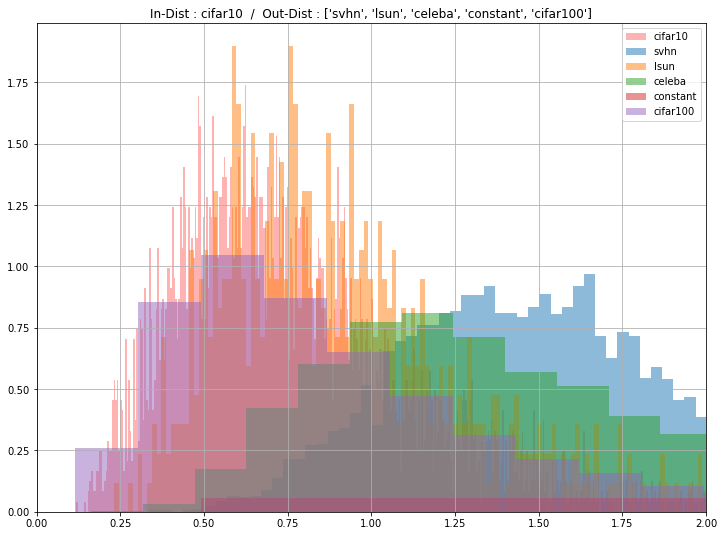

In [7]:
args = [cifar_Gradients, svhn_Gradients,  lsun_Gradients,  celeba_Gradients, constant_Gradients, cifar100_Gradients]
bins = [3000, 300, 300, 3000, 100, 3000]
labels = ['cifar10', 'svhn', 'lsun', 'celeba', 'constant', 'cifar100']
xlim = [0, 2]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)

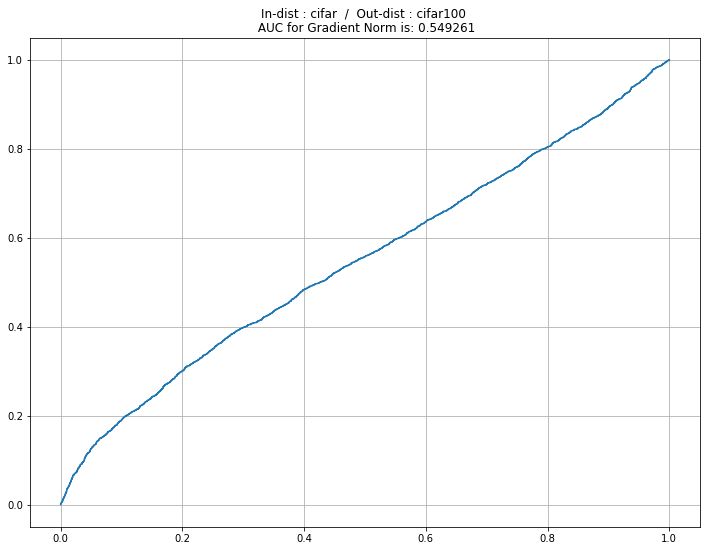

In [8]:
args = [cifar_Gradients, cifar100_Gradients]
labels = ['cifar', 'cifar100']
AUROC(*args, labels=labels)

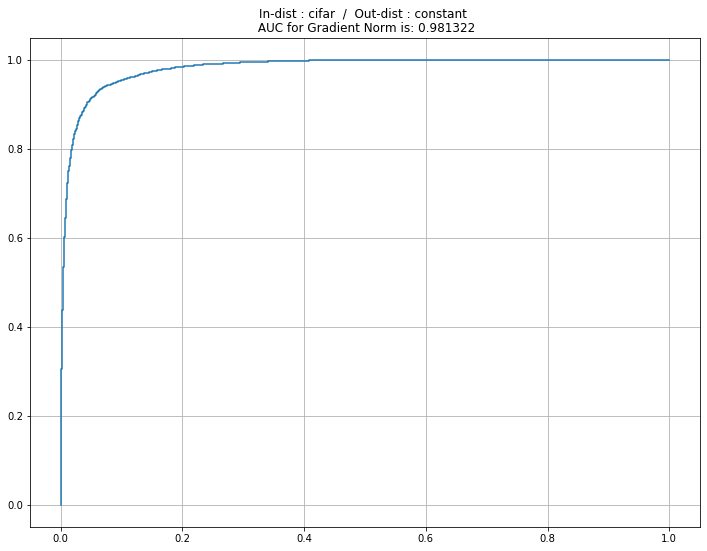

In [9]:
args = [cifar_Gradients, constant_Gradients]
labels = ['cifar', 'constant']
AUROC(*args, labels=labels)

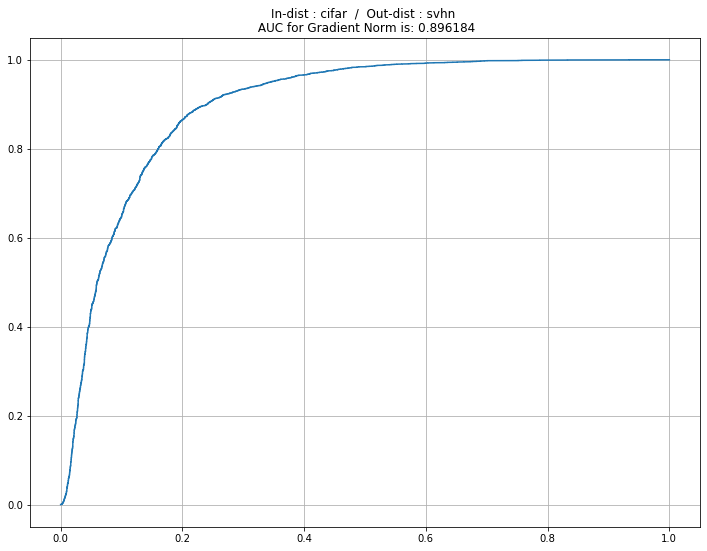

In [10]:
args = [cifar_Gradients, svhn_Gradients]
labels = ['cifar', 'svhn']
AUROC(*args, labels=labels)

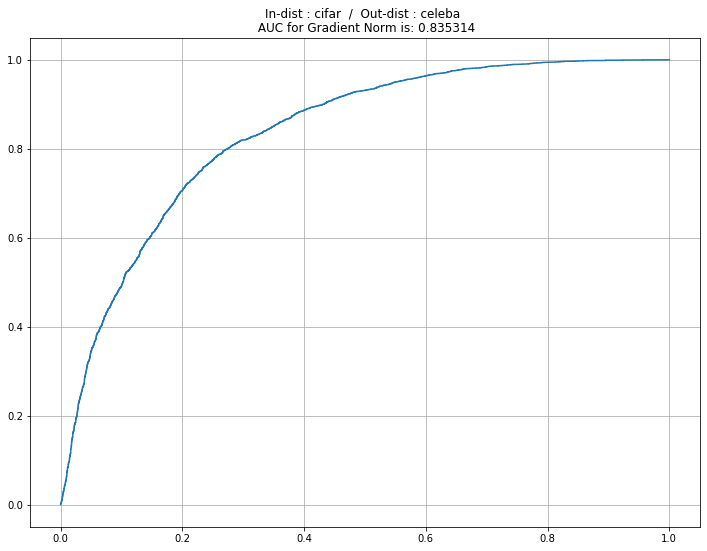

In [11]:
args = [cifar_Gradients, celeba_Gradients]
labels = ['cifar', 'celeba']
AUROC(*args, labels=labels)

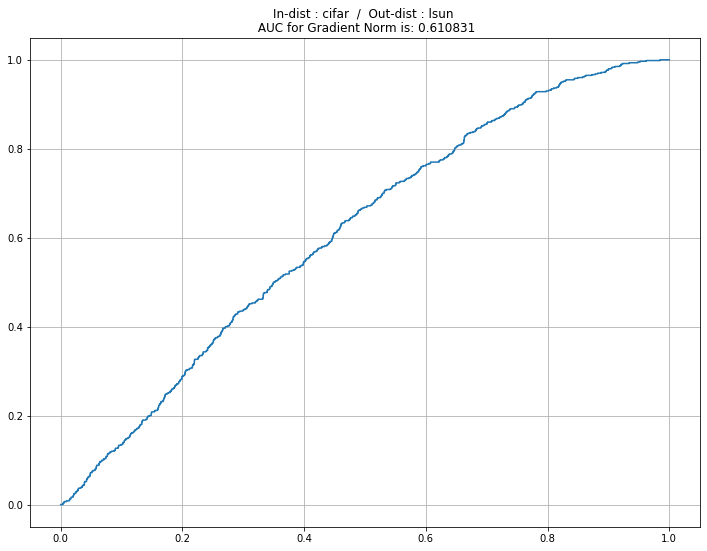

In [12]:
args = [cifar_Gradients, lsun_Gradients]
labels = ['cifar', 'lsun']
AUROC(*args, labels=labels)

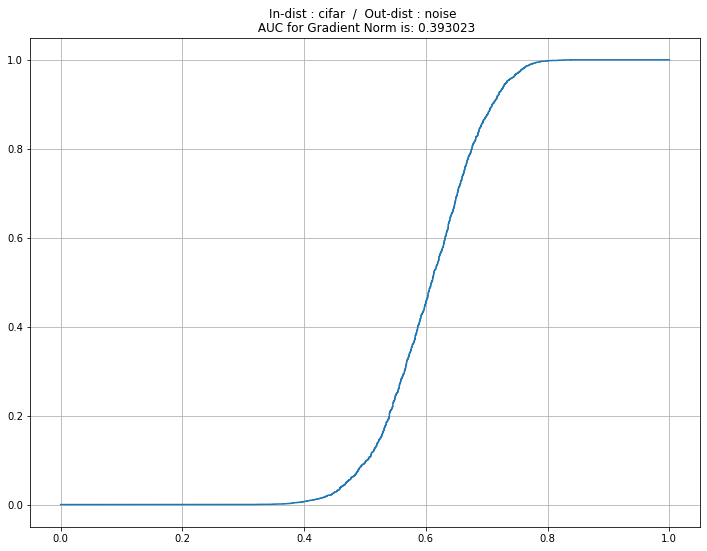

In [13]:
args = [cifar_Gradients, noise_Gradients]
labels = ['cifar', 'noise']
AUROC(*args, labels=labels)

# FMNIST

In [ ]:
train_dist = 'fmnist'
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=train_dist)

dicts = [netE.conv1.weight]

# Calculate the Fisher & Score (for FMNIST)

In [ ]:
noise=0

Grads, normalize_factor = Calculate_fisher(netE,
                                           netG,
                                           TRAIN_loader(option='fmnist'),
                                           dicts = dicts,
                                           opt=opt,
                                           noise=noise
                                          )
fmnist_Gradients = Calculate_score(netE,
                                   netG,
                                   TEST_loader(train_dist='fmnist', target_dist='fmnist'),
                                   dicts,
                                   Grads,
                                   normalize_factor,
                                   max_iter=5000,
                                   opt=opt,
                                   with_label=opt.with_label,
                                   noise=noise
                                  )
kmnist_Gradients = Calculate_score(netE,
                                  netG,
                                  TEST_loader(train_dist='fmnist', target_dist='kmnist'),
                                  dicts,
                                  Grads,
                                  normalize_factor,
                                  max_iter=5000,
                                  opt=opt,
                                  with_label=opt.with_label,
                                   noise=noise
                                 )

omni_Gradients = Calculate_score(netE,
                                  netG,
                                  TEST_loader(train_dist='fmnist', target_dist='omniglot'),
                                  dicts,
                                  Grads,
                                  normalize_factor,
                                  max_iter=5000,
                                  opt=opt,
                                  with_label=True,
                                 noise=noise
                                 )
mnist_Gradients = Calculate_score(netE,
                                  netG,
                                  TEST_loader(train_dist='fmnist', target_dist='mnist'),
                                  dicts,
                                  Grads,
                                  normalize_factor,
                                  max_iter=5000,
                                  opt=opt,
                                  with_label=opt.with_label,
                                  noise=noise
                                 )
noise_Gradients = Calculate_score(netE,
                                  netG,
                                  TEST_loader(train_dist='fmnist', target_dist='noise'),
                                  dicts,
                                  Grads,
                                  normalize_factor,
                                  max_iter=5000,
                                  opt=opt,
                                  with_label=opt.with_label,
                                  noise=noise
                                 )
constant_Gradients = Calculate_score(netE,
                                  netG,
                                  TEST_loader(train_dist='fmnist', target_dist='constant'),
                                  dicts,
                                  Grads,
                                  normalize_factor,
                                  max_iter=5000,
                                  opt=opt,
                                  with_label=opt.with_label,
                                     noise=noise
                                 )

# Visualize

In [ ]:
args = [fmnist_Gradients, kmnist_Gradients, omni_Gradients, constant_Gradients, mnist_Gradients, noise_Gradients]
bins = [100, 100, 100, 100, 100, 100]
labels = ['fmnist', 'kmnist', 'omniglot', 'constant', 'mnist', 'noise']
xlim = [0, 5]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)

In [ ]:
args = [fmnist_Gradients, mnist_Gradients]
labels = ['fmnist', 'mnist']
AUROC(*args, labels=labels)

In [ ]:
args = [fmnist_Gradients, kmnist_Gradients]
labels = ['fmnist', 'kmnist']
AUROC(*args, labels=labels)

In [ ]:
args = [fmnist_Gradients, omni_Gradients]
labels = ['fmnist', 'omniglot']
AUROC(*args, labels=labels)

In [ ]:
args = [fmnist_Gradients, constant_Gradients]
labels = ['fmnist', 'constant']
AUROC(*args, labels=labels)

In [ ]:
args = [fmnist_Gradients, noise_Gradients]
labels = ['fmnist', 'noise']
AUROC(*args, labels=labels)

In [ ]:
VAE, Only conv1.weight, VanilaFisher
# FMNIST
## sigma = 0.02
### mnist : 0.987
### kmnist : 0.995
### omni : 1.0
### const : 0.976 ..(error)
### noise : 0.978

## sigma = 0
### mnist : 0.988
### kmnist : 0.995
### omni : 1.0
### const : 0.995
### noise : 0.982

# CIFAR10
## sigma = 0
### svhn : 0.878
### const : 0.978
### celeba : 0.783
### lsun : 0.52
### cifar100 : 0.54
### noise : 0.09